In [38]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import pandas as pd
import numpy as np
from datetime import datetime

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

plt.style.use('seaborn')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5
rcParams['lines.linewidth'] = 2
# plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':50})

In [39]:
location = r"E:\MYLEARN\2-ANALYTICS-DataScience\datasets\capstone-sales_train_v2.csv"

In [40]:
data = pd.read_csv(location)


In [41]:
# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')

# data = pd.read_excel(location, 
#                      parse_dates =["Order_Date"] 
#                      index_col   = "Order_Date")

# data.head()

In [42]:
data.shape

(2935849, 6)

In [43]:
data.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [44]:
data.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [45]:
# basic stats on the data
data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [46]:
# calculate the total sales per day (Price * count)
data['Sales'] = data['item_price'] * data['item_cnt_day']

In [47]:
data.sample(6)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Sales
2632886,16.05.2015,28,35,20920,1719.0,1.0,1719.0
1111320,24.11.2013,10,44,21723,199.0,1.0,199.0
2106398,20.11.2014,22,33,3028,2599.0,1.0,2599.0
273944,23.03.2013,2,53,32,349.0,1.0,349.0
444611,03.05.2013,4,27,9670,499.0,1.0,499.0
2528381,27.03.2015,26,5,9411,349.0,1.0,349.0


In [48]:
# is there any null value
data.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
Sales             0
dtype: int64

# Data Exploration & Visualizing time series data

This step includes removing columns we do not need, check missing values, 
aggregate sales by date and so on.

In [49]:
data.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'Sales'],
      dtype='object')

In [50]:
# columns to drop
cols = ['shop_id', 
        'item_id', 
        'item_price', 
        'item_cnt_day'
]

data.drop(cols, axis=1, inplace=True)

In [51]:
# Convert the date string to proper date column
#format = '%Y-%m-%d'
format = '%d.%m.%Y'

data['date'] = pd.to_datetime(data['date'], format=format)

In [52]:
# sort on date, ascending
data.sort_values('date', inplace=True)

In [53]:
# set date as index
data.set_index('date', inplace=True)

In [54]:
# first 5 records -- check the date in ascending
data.head(5)

,date_block_num,Sales
date,,
2013-01-01,0,2500.0
2013-01-01,0,849.0
2013-01-01,0,399.0
2013-01-01,0,899.0
2013-01-01,0,149.0


In [55]:
# check for null values
data.isnull().sum()

date_block_num    0
Sales             0
dtype: int64

In [56]:
# do we have more than 1 sales data for a date?
temp = data.groupby('date')['Sales'].size() 
temp[temp > 1].sort_values(ascending=False)

date
2013-12-28    9434
2013-12-29    9335
2014-12-30    9324
2013-12-30    9138
2014-12-31    8347
2014-12-27    8041
2013-12-31    7765
2013-02-23    7577
2014-12-28    7370
2013-12-21    6773
2013-01-02    6718
2014-12-29    6505
2013-02-22    6437
2014-02-22    6433
2014-12-20    6349
2013-01-03    6298
2013-12-27    6211
2014-01-02    6194
2013-03-08    6124
2013-12-22    6070
2013-03-23    5885
2015-01-02    5740
2013-03-16    5721
2013-02-16    5689
2013-02-09    5684
2014-12-21    5644
2013-01-04    5634
2013-12-14    5601
2013-12-26    5598
2013-03-02    5585
              ... 
2015-10-29    1405
2015-09-02    1401
2015-09-29    1393
2015-10-13    1389
2015-10-15    1374
2015-10-14    1372
2015-04-13    1362
2015-10-27    1361
2015-09-23    1356
2015-10-21    1335
2015-03-16    1334
2015-10-22    1332
2015-10-08    1328
2015-09-14    1304
2015-09-21    1297
2015-04-27    1278
2015-09-30    1252
2015-09-15    1243
2015-10-28    1238
2015-10-26    1224
2015-09-28    1223
2015-05

In [57]:
# aggregate sales by date
data_grouped = data.groupby('date')['Sales'].sum().reset_index()

In [58]:
data_grouped.head(6)

,date,Sales
0,2013-01-01,1362942.00
1,2013-01-02,6020512.03
2,2013-01-03,5436480.11
3,2013-01-04,4755664.00
4,2013-01-05,4587231.00
5,2013-01-06,4272597.00


In [59]:
# Indexing with Time Series Data
data_grouped.set_index('date', inplace=True)

In [60]:
# data range
data_grouped.index.min(), data_grouped.index.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-10-31 00:00:00'))

In [61]:
data_grouped.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-10-22', '2015-10-23', '2015-10-24', '2015-10-25',
               '2015-10-26', '2015-10-27', '2015-10-28', '2015-10-29',
               '2015-10-30', '2015-10-31'],
              dtype='datetime64[ns]', name='date', length=1034, freq=None)

In [62]:
data_grouped.shape

(1034, 1)

An useful aspect of the DatetimeIndex is that the individual date/time components are all available as attributes such as year, month, day, and so on. 

Let’s add a few more columns to data_grouped df, containing the year, month, and weekday name.

In [63]:
# Add columns with year, month, and weekday name
data_grouped['Year']         = pd.DatetimeIndex(data_grouped.index).year
data_grouped['Month']        = pd.DatetimeIndex(data_grouped.index).month
data_grouped['Weekday Name'] = pd.DatetimeIndex(data_grouped.index).weekday_name

# Display a random sampling of 5 rows
data_grouped.sample(5, random_state=0)

,Sales,Year,Month,Weekday Name
date,,,,
2014-10-06,2653165.94,2014,10,Monday
2013-11-12,2003562.00,2013,11,Tuesday
2015-06-14,1846916.84,2015,6,Sunday
2013-11-13,2022188.00,2013,11,Wednesday
2014-03-02,3499553.99,2014,3,Sunday


#### Examples of time based indexing

In [64]:
data_grouped.loc['2013-01-10']

Sales           2.29534e+06
Year                   2013
Month                     1
Weekday Name       Thursday
Name: 2013-01-10 00:00:00, dtype: object

In [65]:
# data_grouped.loc['2013']

In [66]:
# data_grouped.loc['2013-01']

In [67]:
# data_grouped.loc['2013-01': '2013-03']

... back to the main code

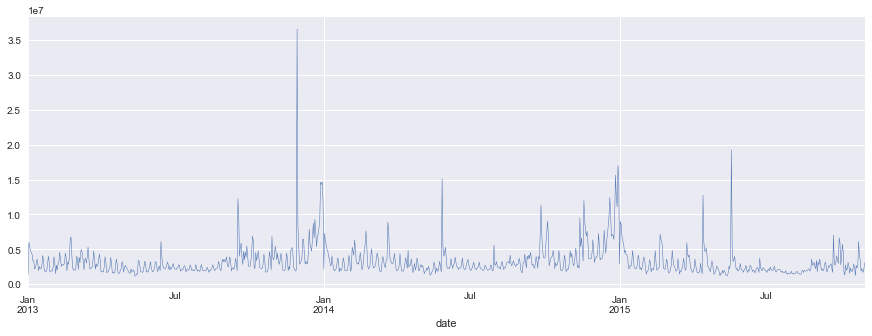

In [68]:
# create a line plot of the full time series of daily sales, 
# using the DataFrame’s plot() method.
data_grouped['Sales'].plot(linewidth=0.5);

 with so many data points, the line plot is crowded and hard to read. Let’s plot the data as dots instead.

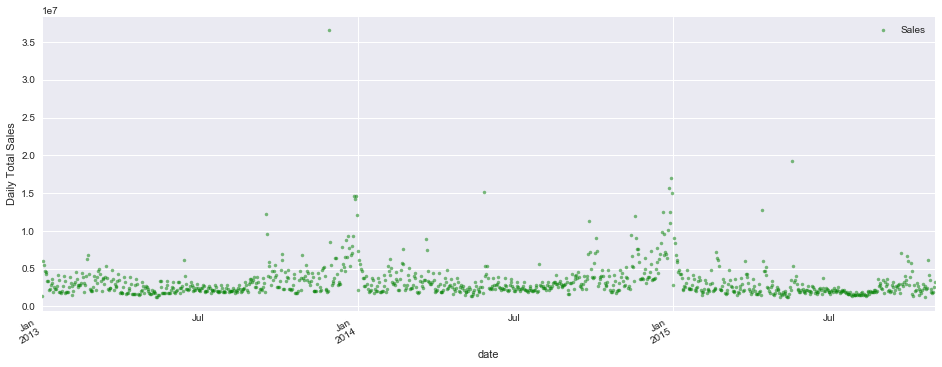

In [69]:
# Use seaborn style defaults and set the default figure size
# sns.set(rc={'figure.figsize':(18, 6)})

cols_plot = ['Sales']

axes      = data_grouped[cols_plot].plot(marker='.', 
                                         color='g',
                                         alpha=0.5, 
                                         linestyle='None', 
                                         figsize=(16, 6), 
                                         subplots=True)

for ax in axes:
    ax.set_ylabel('Daily Total Sales')

** Observation **
1. Every year end, sales picks up. So seasonality is evident
2. Noise/outliers are also evident in the plot
3. Overall trend seems to be flat, but needs further exploration
4. Need to explore if monthly or weekly seasonality also exist

Let’s plot the time series in a single year to investigate further.

## Seasonality analysis

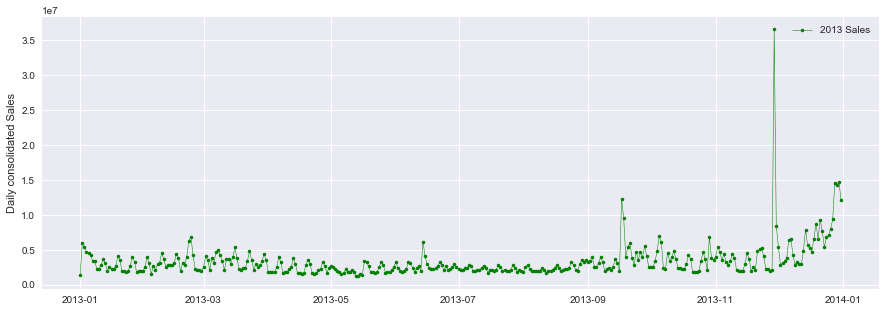

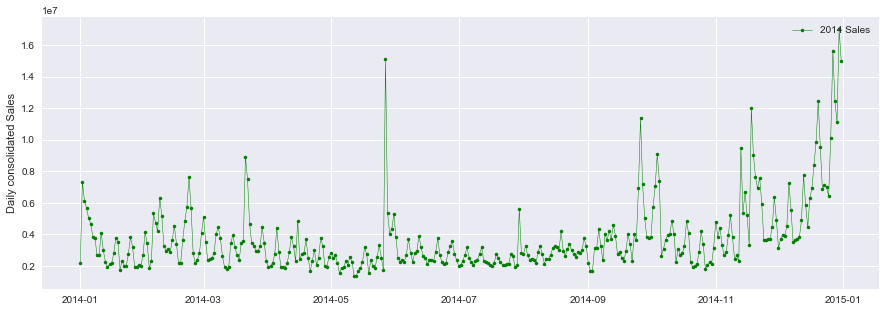

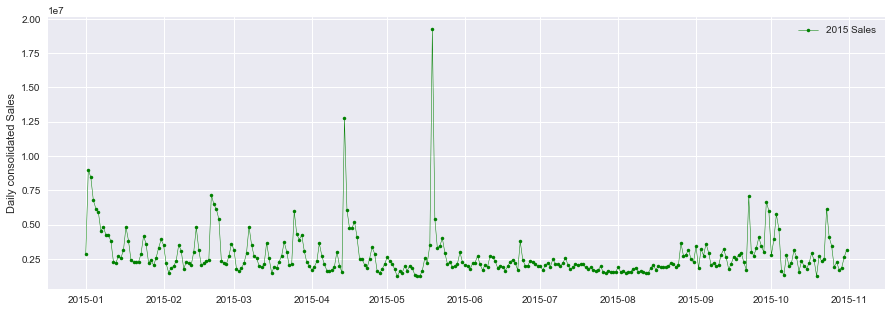

In [70]:
for year in np.unique(data_grouped.Year):
    fig, ax = plt.subplots()
    ax.plot(data_grouped.loc[str(year), 'Sales'],
                             marker='.', 
                             color='g',
                             linestyle='-', 
                             linewidth=0.5, 
                             label=str(year)+' Sales')

    ax.set_ylabel('Daily consolidated Sales');
    ax.legend(loc='upper right');

** Observation **

1. Year end, sales picks up. So yearly seasonality is confirmed
2. odd scatter exists in terms of outliers and noise

Let’s plot the time series over 6 months to investigate further
    - for monthly or weekly sales seasonality

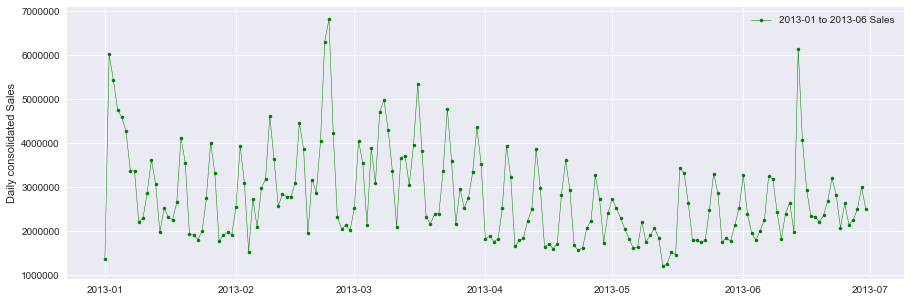

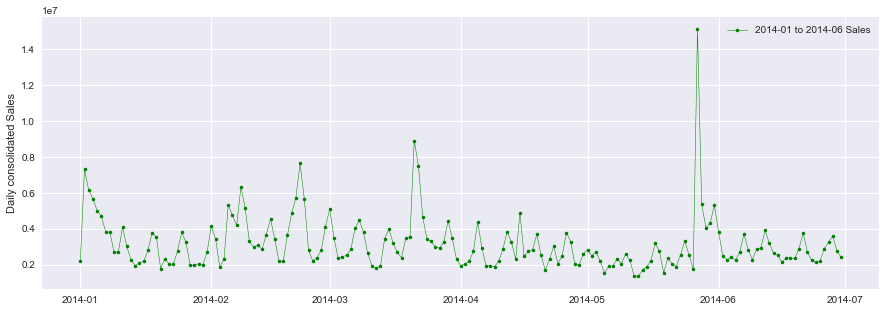

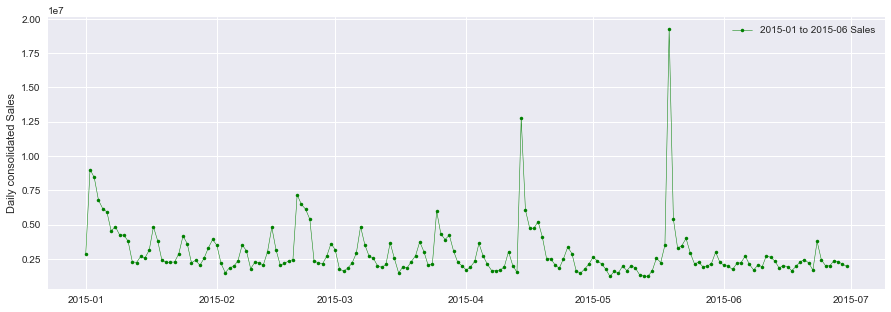

In [71]:
# 6 months plot for every year
for year in np.unique(data_grouped.Year):
    fig, ax = plt.subplots()
    
    start_period = str(year)+'-01'
    end_period   = str(year)+'-06'
    
    ax.plot(data_grouped.loc[start_period:end_period, 'Sales'],
                             marker='.', 
                             color='g',
                             linestyle='-', 
                             linewidth=0.5, 
                             label=start_period + 
                                    ' to '+ 
                                    end_period+ 
                                    ' Sales')

    ax.set_ylabel('Daily consolidated Sales');
    ax.legend(loc='upper right');

** Observation **

1. There is no monthly seasonality but weekly seasonality is evident. we will zoom in further to conclude this aspect

let us plot for 2 months every year to conclude on weekly seasonality. Say Month of Mar and Apr, for example.


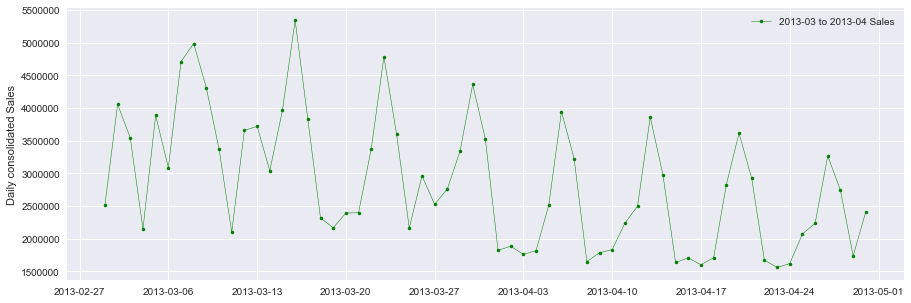

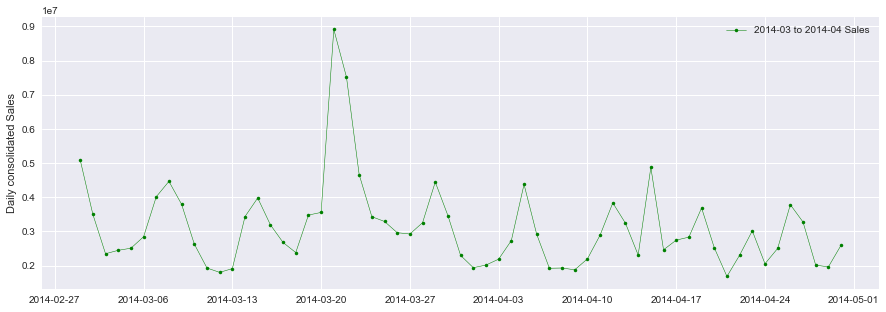

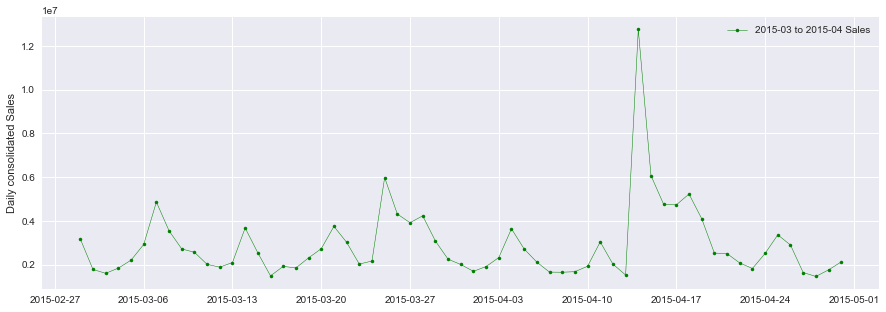

In [72]:
# 2 months plot for every year
for year in np.unique(data_grouped.Year):
    fig, ax = plt.subplots()
    
    start_period = str(year)+'-03'
    end_period   = str(year)+'-04'
    
    ax.plot(data_grouped.loc[start_period:end_period, 'Sales'],
                             marker='.', 
                             color='g',
                             linestyle='-', 
                             linewidth=0.5, 
                             label=start_period + 
                                    ' to '+ 
                                    end_period+ 
                                    ' Sales')

    ax.set_ylabel('Daily consolidated Sales');
    ax.legend(loc='upper right');

** Observation **

1. The weekly seasonality is evident. 

## Seasonality analysis - using box plots

Explore the seasonality of data with box plots, using seaborn’s boxplot() function to group the data by different time periods and display the distributions for each group. 

We’ll first group the data by month, to visualize yearly seasonality.

In [74]:
data_grouped.head()

,Sales,Year,Month,Weekday Name
date,,,,
2013-01-01,1362942.00,2013,1,Tuesday
2013-01-02,6020512.03,2013,1,Wednesday
2013-01-03,5436480.11,2013,1,Thursday
2013-01-04,4755664.00,2013,1,Friday
2013-01-05,4587231.00,2013,1,Saturday


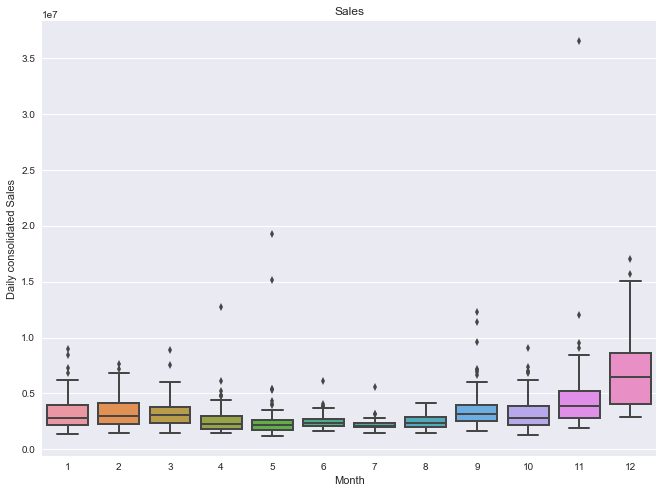

In [76]:
fig, ax = plt.subplots(figsize=(11, 8))

sns.boxplot(data=data_grouped, x='Month', y='Sales', ax=ax)

ax.set_ylabel('Daily Sales')
ax.set_title('Sales')

ax.set_ylabel('Daily consolidated Sales');

** Observation **

1. sales picks up in the months of Nov and Dec (festival time)
2. sales dips during summer
3. sparadic outlier sales across the months

#### group the sales time series by day of the week, to explore weekly seasonality.

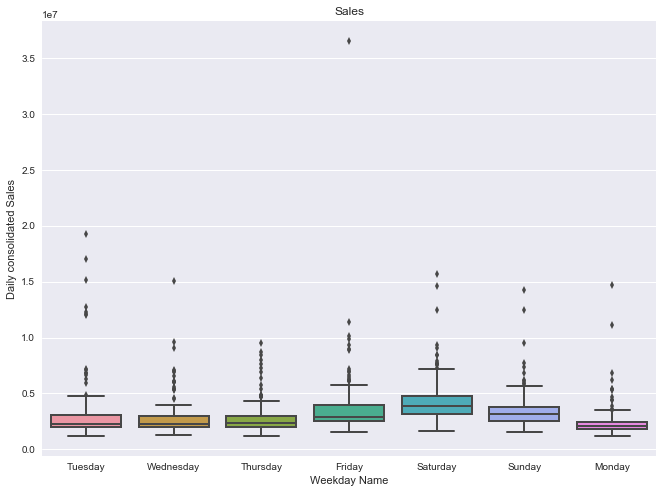

In [78]:
fig, ax = plt.subplots(figsize=(11, 8))

sns.boxplot(data=data_grouped, x='Weekday Name', y='Sales', ax=ax)

ax.set_ylabel('Daily Sales')
ax.set_title('Sales')

ax.set_ylabel('Daily consolidated Sales');

As expected, sales is significantly higher on weekdays than on weekends. 

## Checking for trend

In [79]:
# define a function to check trend and plot

def detect_trend (X_df):
    coefficients, residuals, _, _, _ = np.polyfit(range(len(X_df)),
                                                  X_df,
                                                  1,
                                                  full=True)

    mse = residuals[0]/(len(X_df))
    nrmse = np.sqrt(mse)/(X_df.max() - X_df.min())

    print('Slope ' + str(coefficients[0]))
    print('NRMSE: ' + str(nrmse))

    plt.xticks(rotation=90)
    plt.plot(X_df, 
             marker='.', 
             linestyle='-', 
             linewidth=0.5,
             color='g',  
             label='Original')
    
    plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(X_df))],
             marker='o', 
             markersize=2, 
             linestyle='-', 
             linewidth=0.5,
             color='orange',
             label='Regression line');
    plt.legend()
    plt.show()

Slope -81.96087407425203
NRMSE: 0.06382085013251919


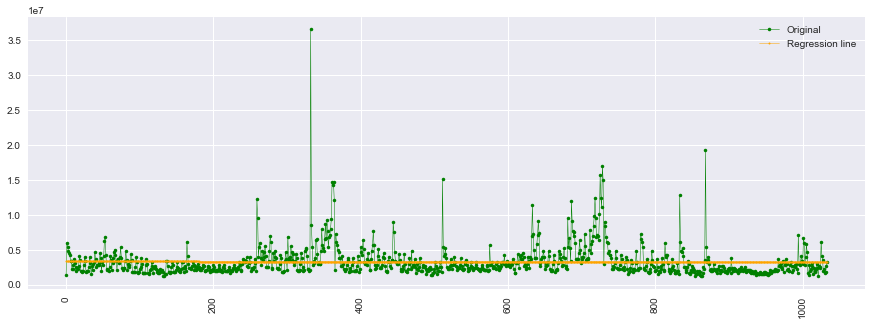

In [80]:
# check for overall trend
detect_trend(data_grouped['Sales'].values)

** observation **
- very little/marginal downward trend


check for trend every year

Slope 7553.695961557097
NRMSE: 0.06914292898851347


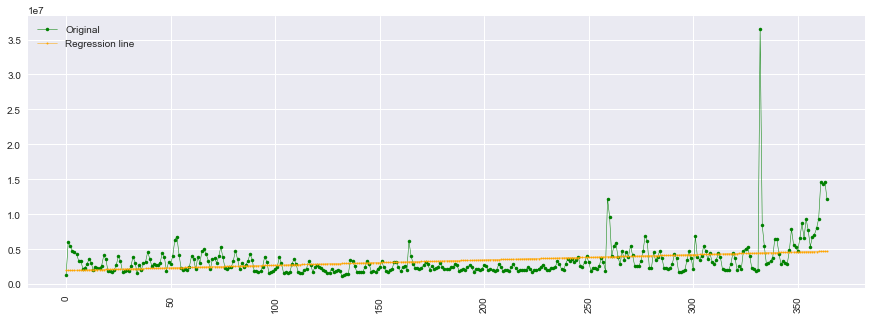

Slope 7773.262991528029
NRMSE: 0.13433306156741404


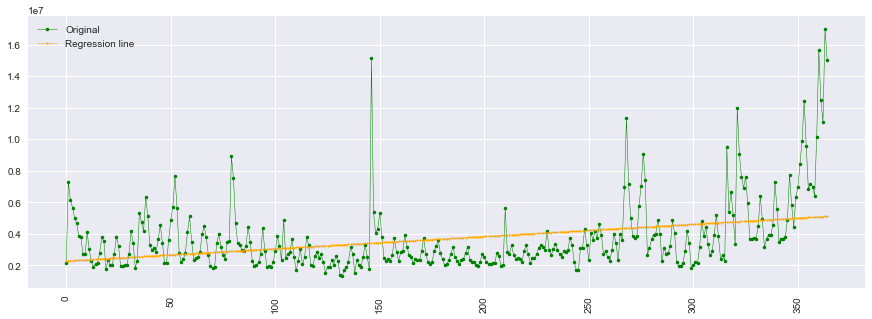

Slope -3464.583848401051
NRMSE: 0.09078236220948212


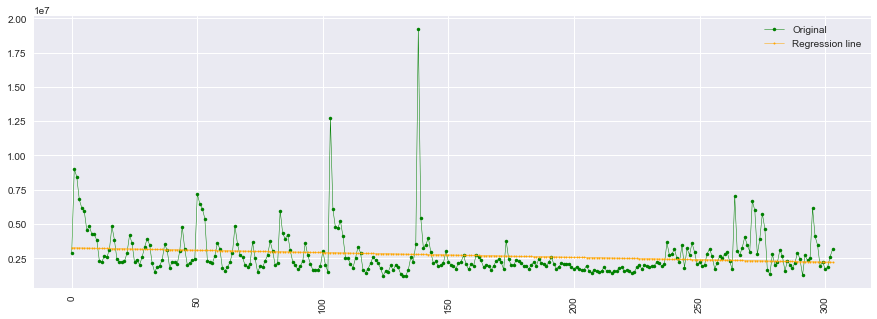

In [81]:
for year in np.unique(data_grouped.Year):
    detect_trend(data_grouped.loc[str(year)]['Sales'].values)

** Obervation **

- little trend observed (yearly) - negligible

# So how bad is the Time Series in terms of stationarity

### (1) Stationarity

- Data points are often __non-stationary__ or have means, variances and covariances that _change over time_. 

- Non-stationary behaviors can be trends, cycles, random walks or combinations of the three.

- Non-stationary data, as a rule, are _unpredictable and cannot be modeled or forecasted._ The results obtained by using non-stationary time series may be spurious in that they may indicate a relationship between two variables where one does not exist. 

- In order to receive consistent, reliable results, the non-stationary data needs to be transformed into stationary data.


- A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. 

> - constant mean
> - constant variance
> - an autocovariance that does not depend on time.

- Though stationarity assumption is taken in many TS models, almost __none of practical time series are stationary.__

- Most of the TS models work on the _assumption that the TS is stationary._ 

- Intuitively, we can say that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 

#### Why do we care about stationarity? 

- A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.

- Most of the models we use in TSA assume covariance-stationarity (#3 above). This means the descriptive statistics these models predict e.g. means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

> "For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables." 

- With that said, most TS we encounter in finance is NOT stationary. Therefore a large part of TSA involves identifying if the series we want to predict is stationary, and if it is not we must find ways to transform it such that it is stationary. 

#### check stationarity using the following methods:-

(1) __Rolling Plots__: review a time series plot ( moving average or moving variance) of the data and visually check if there are any obvious trends or seasonality.

(2) __Summary Statistics__: review the summary statistics for the data for seasons or random partitions and check for obvious or significant differences.

(3) __Statistical Tests__: use statistical tests to check if the expectations of stationarity are met or have been violated.

> __Dickey-Fuller Test__: This is one of the statistical tests for checking stationarity. 

> Here the null hypothesis is that the TS is non-stationary. 

> The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. 

> If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

#### Stationarity test : Method 1 : Plots 


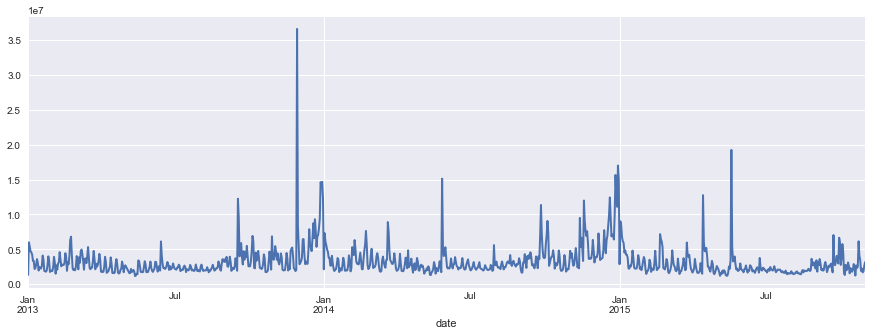

In [82]:
data_grouped['Sales'].plot();

#### Stationarity test : Method 2 : Summary Statistics

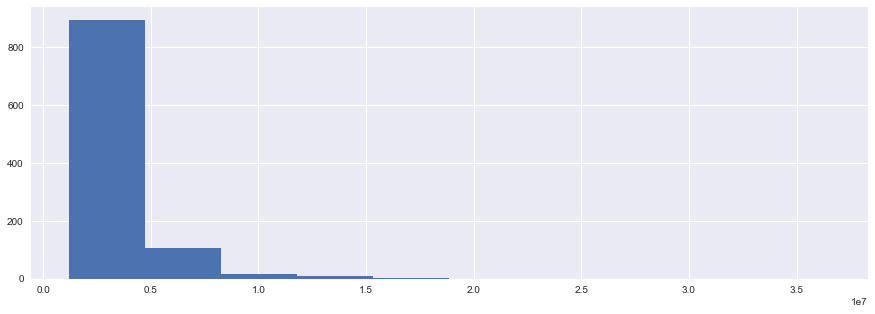

In [83]:
data_grouped['Sales'].hist();

- split the time series into 2 contiguous sequences. 

- calculate the mean and variance of each group of numbers and compare the values.

In [84]:
X = data_grouped['Sales'].values
split = len(X) / 2
split = int(split)

X1, X2 = X[0:split], X[split:]

mean1, mean2 = X1.mean(), X2.mean()
var1,  var2  = X1.var(),  X2.var()

print('mean1     = {:10.2f}, mean2     = {:10.2f}'.format(mean1, mean2))
print('variance1 = {:10.2f}, variance2 = {:10.2f}'.format(var1,  var2))

mean1     = 3303750.14, mean2     = 3270575.48
variance1 = 5459163807450.84, variance2 = 4721392128621.14


- the mean and variance values are different. But in the same ball-park range.
- Hence the time series is stationary


#### Stationarity test : Method 3 : Augmented Dickey-Fuller test - (ADF) test 

- The intuition behind the test is that it determines how strongly a time series is defined by a trend. (i.e no stationarity)

$ H_0 : $ - time series is __not stationary __

$ H_A : $ - time series is stationary 

p-value <= 0.05: Reject the null hypothesis ($H_0$), the data does not have a unit root and is stationary.

> p-value > 0.05: Fail to reject the null hypothesis ($H_0$), the data has a unit root and is non-stationary.

In [85]:
for year in np.unique(data_grouped.Year):
    #detect_trend(data_grouped.loc[str(year)]['Sales'].values)

    X = data_grouped.loc[str(year)]['Sales'].values

    result = adfuller(X)
    
    print('\nFor the year : ', year)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%5s: %8.3f' % (key, value))

X = data_grouped['Sales'].values

result = adfuller(X)

print('\nFor the CONSOLIDATED 4 years')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%5s: %8.3f' % (key, value))    


For the year :  2013
ADF Statistic: -0.729668
p-value: 0.838914
Critical Values:
	   1%:   -3.449
	   5%:   -2.870
	  10%:   -2.571

For the year :  2014
ADF Statistic: 0.743996
p-value: 0.990676
Critical Values:
	   1%:   -3.449
	   5%:   -2.870
	  10%:   -2.571

For the year :  2015
ADF Statistic: -10.697341
p-value: 0.000000
Critical Values:
	   1%:   -3.452
	   5%:   -2.871
	  10%:   -2.572

For the CONSOLIDATED 4 years
ADF Statistic: -6.018220
p-value: 0.000000
Critical Values:
	   1%:   -3.437
	   5%:   -2.864
	  10%:   -2.568


#### conclusion

1. Consolidated years - p-value is less than .05 or .01. hence H0 CAN be rejected. 
3. H0 : Not stationary
2. Means TS is stationary

    2. Yearly- p-value method : p-value is $\lt$ 0.05 so we reject the null hypothesis for yearly TS
  

## Making TS stationary

** define a function to test stationarity **

In [86]:
def test_stationarity(timeseries, reduced_timeseries=None, smoothing_type='R'):
     
    # Plot rolling statistics:
    orig = plt.plot(timeseries,
                    marker='.', 
                    linestyle='-', 
                    linewidth=0.5,
                    color='blue',  
                    label='Original')
    
    mean = plt.plot(reduced_timeseries, 
                    marker='.', 
                    linestyle='-', 
                    linewidth=0.5,
                    color='red',   
                    label='Reduced')
    
    if smoothing_type == 'R':
        title = 'Smoothing by Rolling MA'
    elif smoothing_type == 'E':
        title = 'Smoothing by Exponential weighted MA'
    else:
        title = 'Default MA'
        
    plt.legend(loc='best')
    plt.title(title)
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(reduced_timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print (dfoutput)

### Reduce noise

- Aggregation – taking average for a time period like monthly/weekly averages

- Smoothing – taking rolling averages (Moving average)

- Polynomial Fitting – fit a regression model

#### 1. Smoothing - Moving average

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.

In [87]:
ts = data_grouped['Sales']

In [88]:
moving_avg = ts.rolling(window=30).mean()

In [89]:
moving_avg.head()

date
2013-01-01   NaN
2013-01-02   NaN
2013-01-03   NaN
2013-01-04   NaN
2013-01-05   NaN
Name: Sales, dtype: float64

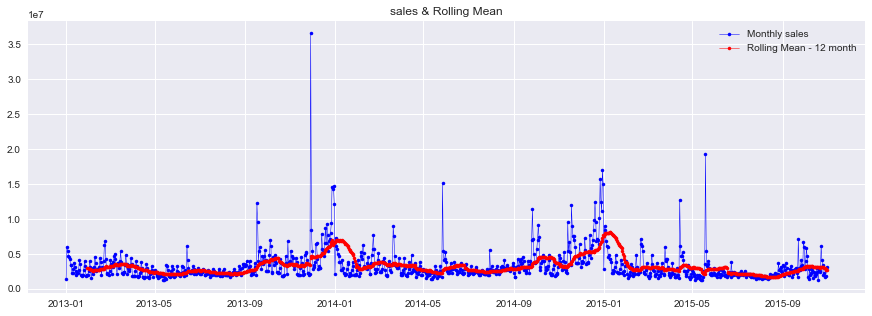

In [90]:
plt.plot(ts, marker='.', linestyle='-', linewidth=0.5, label='Monthly sales', c='b')
plt.plot(moving_avg, marker='.', linestyle='-', linewidth=0.5, color='red', label='Rolling Mean - 12 month');

plt.legend(loc='best')
plt.title('sales & Rolling Mean');

Lets us subtract the rolling means from the original series

Note that since we are taking average of last 30 values, rolling mean is not defined for first 29 values.

In [92]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.head(30)

date
2013-01-01             NaN
2013-01-02             NaN
2013-01-03             NaN
2013-01-04             NaN
2013-01-05             NaN
2013-01-06             NaN
2013-01-07             NaN
2013-01-08             NaN
2013-01-09             NaN
2013-01-10             NaN
2013-01-11             NaN
2013-01-12             NaN
2013-01-13             NaN
2013-01-14             NaN
2013-01-15             NaN
2013-01-16             NaN
2013-01-17             NaN
2013-01-18             NaN
2013-01-19             NaN
2013-01-20             NaN
2013-01-21             NaN
2013-01-22             NaN
2013-01-23             NaN
2013-01-24             NaN
2013-01-25             NaN
2013-01-26             NaN
2013-01-27             NaN
2013-01-28             NaN
2013-01-29             NaN
2013-01-30   -1.030414e+06
Name: Sales, dtype: float64

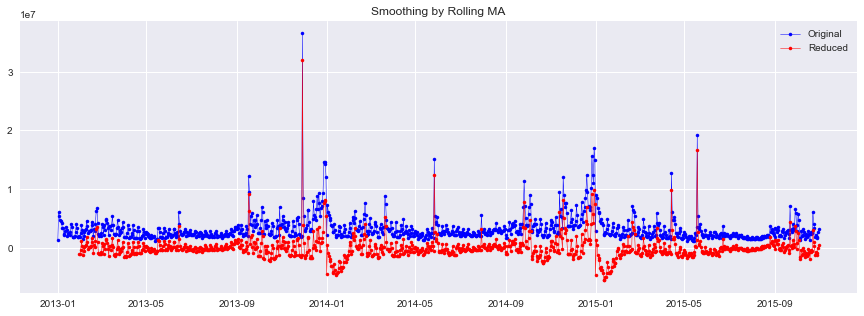

Results of Dickey-Fuller Test:
Test Statistic                -8.316494e+00
p-value                        3.668818e-13
#Lags Used                     1.700000e+01
Number of Observations Used    9.870000e+02
Critical Value (1%)           -3.436993e+00
Critical Value (5%)           -2.864473e+00
Critical Value (10%)          -2.568332e+00
dtype: float64


In [93]:
ts_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts, ts_moving_avg_diff, 'R')

#### observation

- The rolling values appear to be varying slightly but there is no specific trend. 
- Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a __stationary series.__

#### conclusion

1. p-value method : p-value of 3.668818e-13 is $\lt$ 0.05 so we REJECT the null hypothesis. The null hypothesis is : the TS is NON-STATTIONARY. Hence it is proved that TS is stationary
    
2. Critical value  : our statistic value of -6.196939e+00 is more than the value of -3.711212e+00 at 1%. So this falls in the rejection region. Hence we REJECT the null hypothesis. i.e TS is stationary


#### 2. exponentially weighted moving average

In [94]:
ewma = pd.Series.ewm

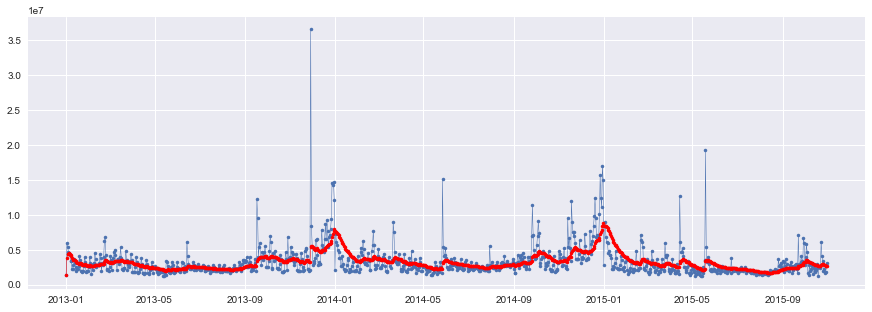

In [95]:
fwd_exp_weighted_avg = ewma(ts, span=30).mean() 

plt.plot(ts, marker='.', linestyle='-', linewidth=0.5,)
plt.plot(fwd_exp_weighted_avg, marker='.', linestyle='-', linewidth=0.5, color='red');

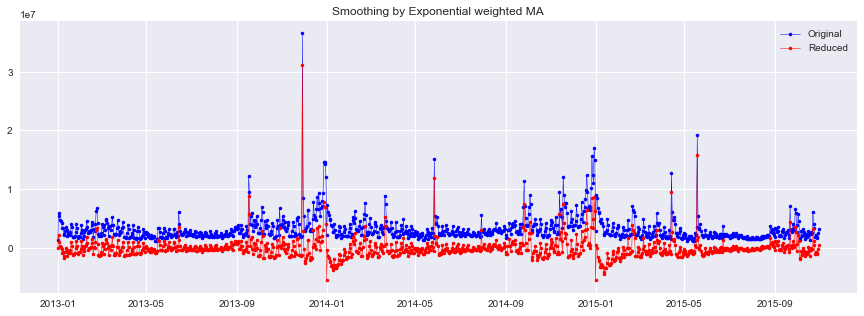

Results of Dickey-Fuller Test:
Test Statistic                -8.099144e+00
p-value                        1.314165e-12
#Lags Used                     1.500000e+01
Number of Observations Used    1.018000e+03
Critical Value (1%)           -3.436790e+00
Critical Value (5%)           -2.864383e+00
Critical Value (10%)          -2.568284e+00
dtype: float64


In [96]:
ts_ewma_diff = ts - fwd_exp_weighted_avg
test_stationarity(ts, ts_ewma_diff, 'E')

## decompose a time series into its components?

You can do a classical decomposition of a time series by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual.

The __seasonal_decompose__ in __statsmodels__ implements this conveniently.

visualize our data using a method called time-series decomposition that allows us to decompose our time series into 3 distinct components: 
    - trend, 
    - seasonality, and 
    - noise.

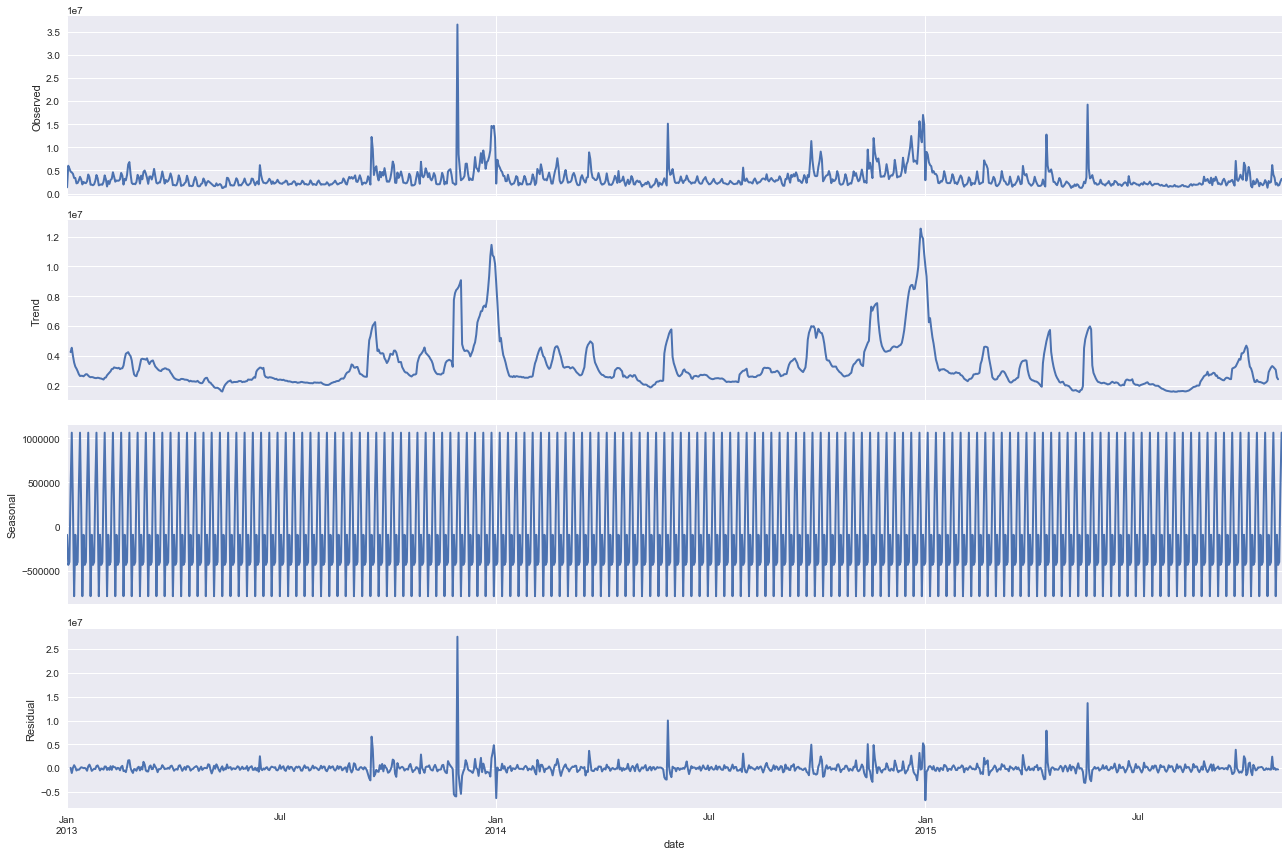

In [97]:
# Multiplicative Decomposition 

rcParams['figure.figsize'] = 18, 12

result_additive = seasonal_decompose(data_grouped['Sales'],
                                     model='additive')

fig = result_additive.plot()

The plot above clearly shows that the sales of furniture is stable, 
No obvious seasonality.

# Time series forecasting with ARIMA

- ARIMA, short for __‘Auto Regressive Integrated Moving Average’__ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

- Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

- An ARIMA model is characterized by 3 terms: p, d, q where,

    - p is the order of the AR term
    - q is the order of the MA term
    - d is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’. 

#### d term

- The first step to build an ARIMA model is to make the time series stationary. Why?

- Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

- The most common approach is to __difference__ it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

- The value of __d__, therefore, is the minimum number of differencing needed to make the series stationary. 

- And if the time series is already stationary, then d = 0.

#### Next, what are the ‘p’ and ‘q’ terms?

- ‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors. 

- And ‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

** ARIMA model in words:**

Predicted $Y_t$ = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

# (1) How to find the order of differencing (d) in ARIMA model

- The purpose of differencing it to make the time series stationary.

- But we need to be careful to not over-difference the series. Because, an over differenced series may still be non-stationary, which in turn will affect the model parameters.

- ** So how to determine the right order of differencing? **

- The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

- If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. 

- On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

(1) First, check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.

    - Because, you need differencing only if the series is non-stationary. 
    - Else, no differencing is needed, that is, d=0.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [98]:
data_grouped.columns

Index(['Sales', 'Year', 'Month', 'Weekday Name'], dtype='object')

we  shall use ** ts ** series for our further analysis

In [99]:
ts.head()

date
2013-01-01    1362942.00
2013-01-02    6020512.03
2013-01-03    5436480.11
2013-01-04    4755664.00
2013-01-05    4587231.00
Name: Sales, dtype: float64

In [100]:
result = adfuller(ts)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -6.018220
p-value: 0.000000


Since P-value is less than the significance level of 0.05, that means we should reject the null hypothesis.

H0 : TS is non stationary
    
It means the TS is stationary

let us check with ACF plot


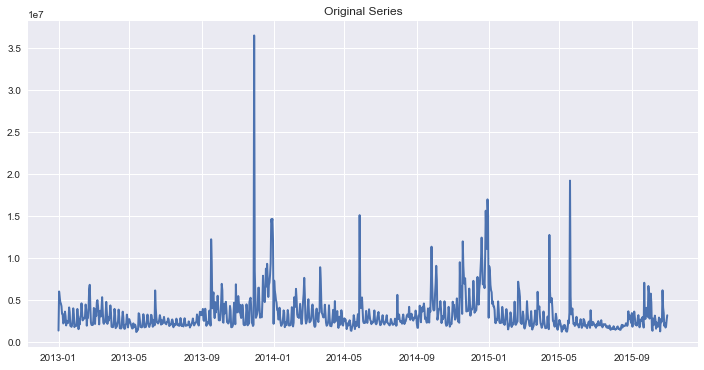

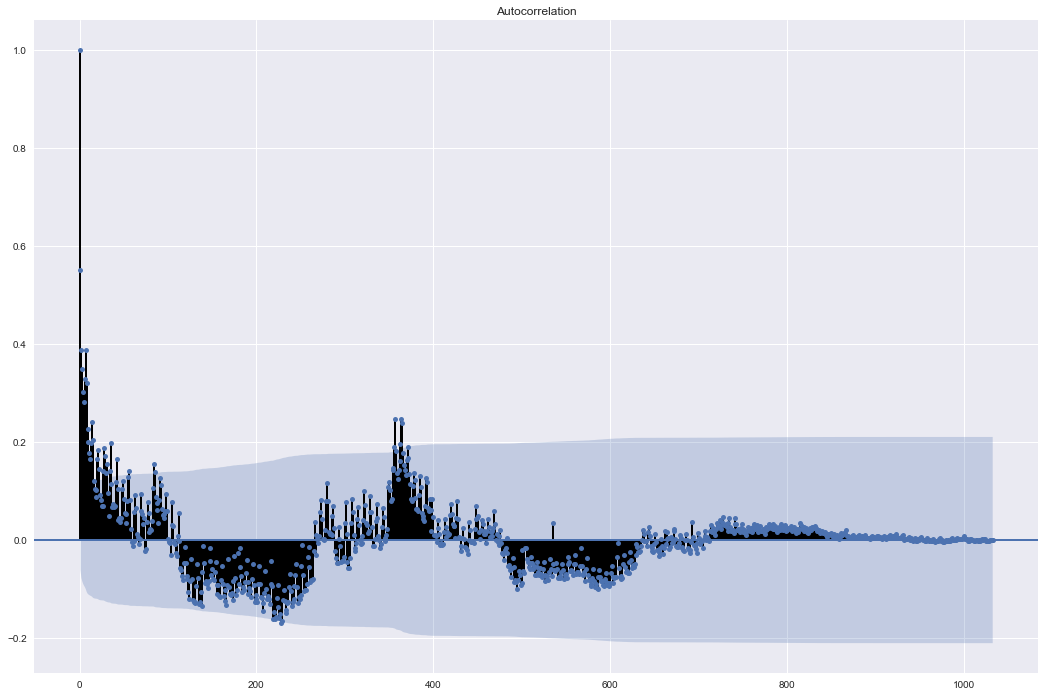

In [101]:
# Original Series
# fig, axes = plt.subplots(6, 1, sharex=True)
#fig, axes = plt.subplots(3, 2, figsize=(11, 8))
plt.figure(figsize=(12, 6))

plt.plot(ts)
plt.title('Original Series')
acf0 = plot_acf(ts)

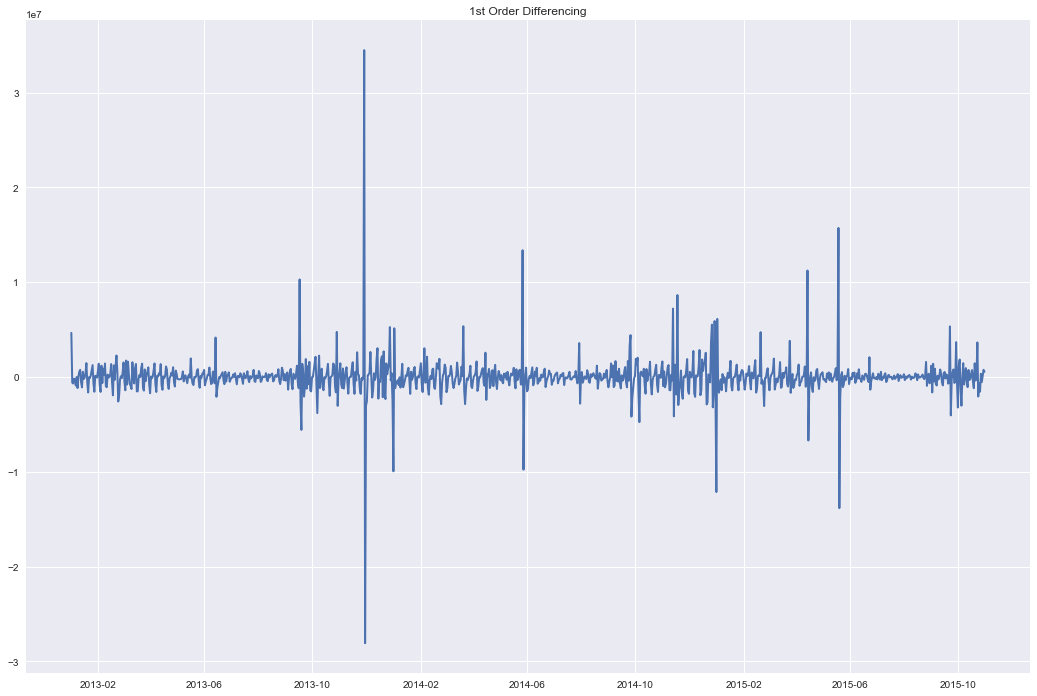

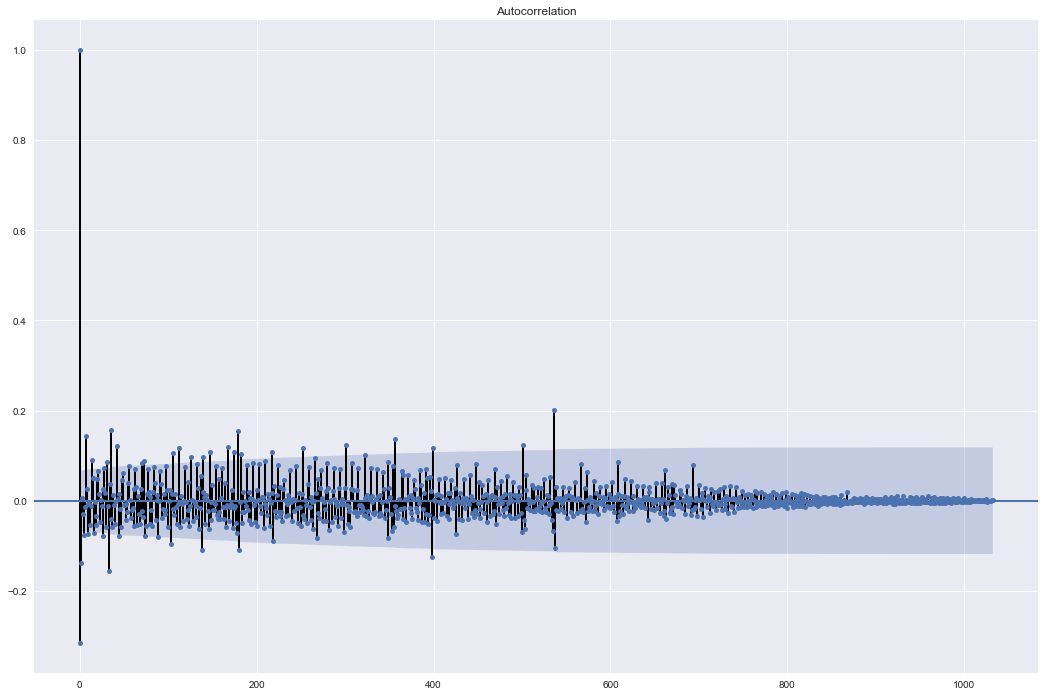

In [102]:
# 1st order Differencing
plt.plot(ts.diff()); 
plt.title('1st Order Differencing')
acf1 = plot_acf(ts.diff().dropna())

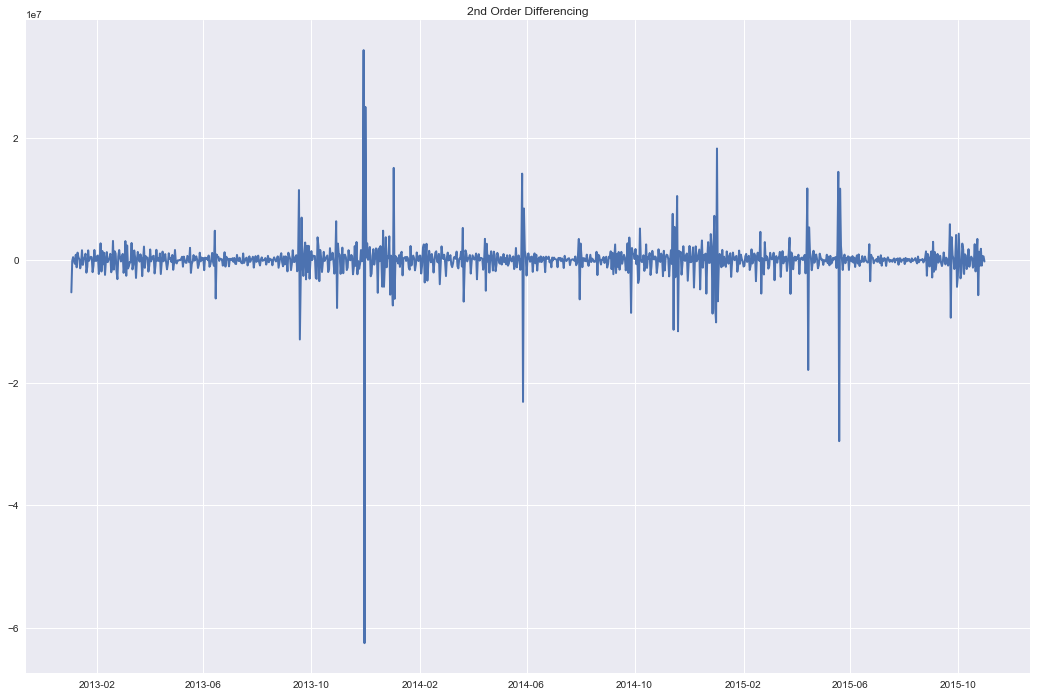

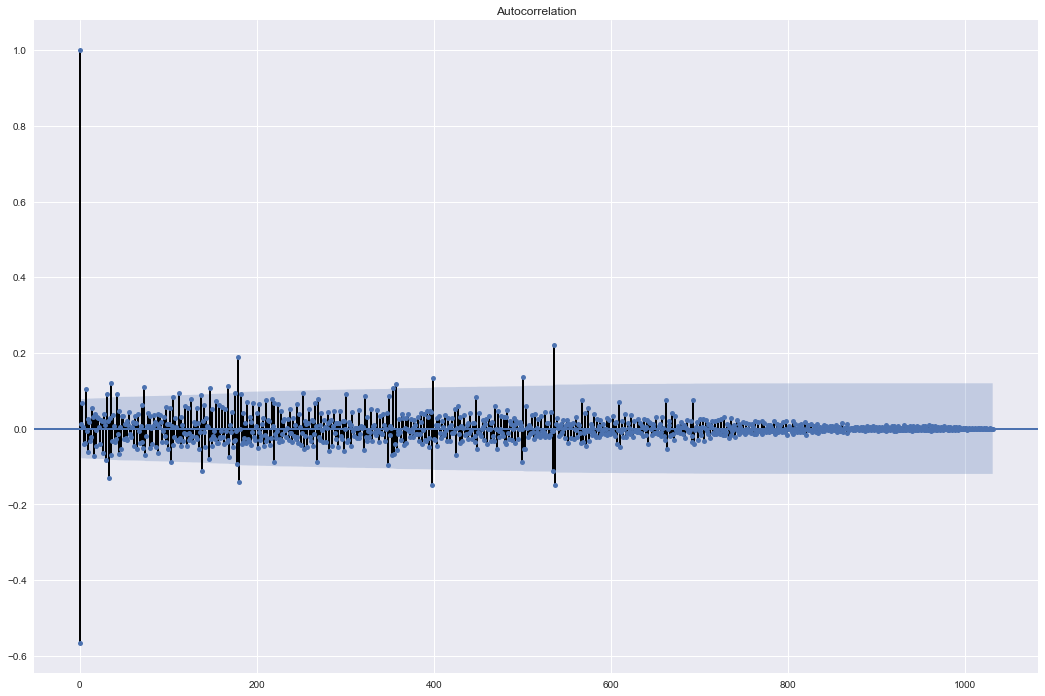

In [103]:
# 2nd order Differencing
plt.plot(ts.diff().diff()); 
plt.title('2nd Order Differencing')
acf2 = plot_acf(ts.diff().diff().dropna())

#### Observation

- For the above series, the time series reaches stationarity without ANY differencing. !!!

- Look at the 1st order differencing, with a lag of 1 or 2, the ACF goes into negative zone

- we will consider d = 0 (or we can try with 1)

# (2) How to find the order of the AR term (p)

- After differencing the TS, we need to ensure there is no autocorrelation in the differenced time series 

- determine the AR and MA terms

- You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

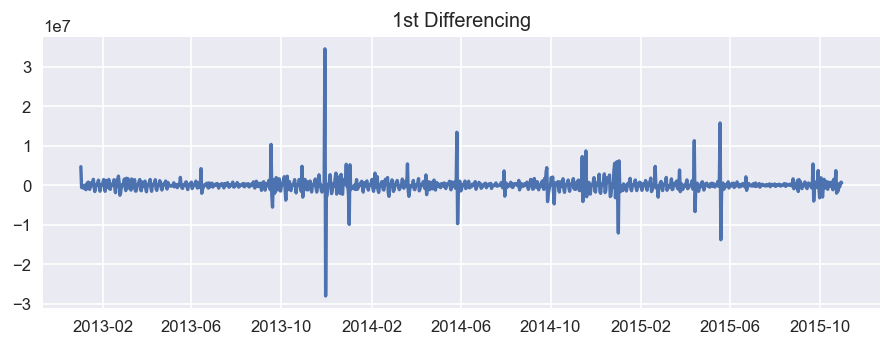

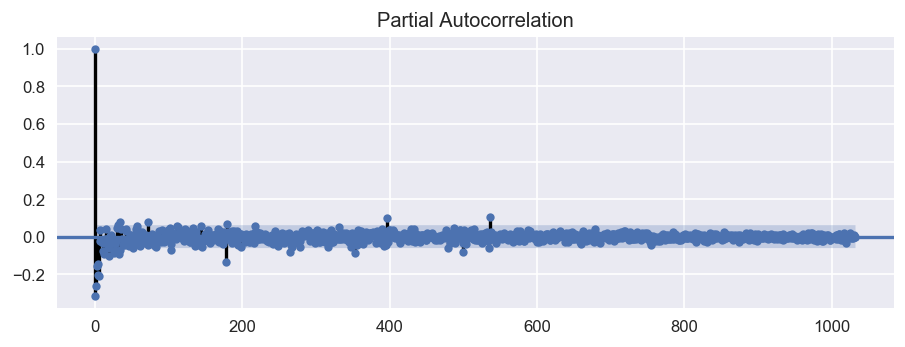

In [104]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
#fig, axes = plt.subplots(1, 2, sharex=True)

plt.plot(ts.diff()); 
plt.title('1st Differencing')
#plt.set(ylim=(0,5))

pacf = plot_pacf(ts.diff().dropna())

You can observe that the PACF lag 1 itself goes negative

we can be conservative and tentatively fix the p as 0 (we can try with 1 later).

# (3) How to find the order of the MA term (q)

look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

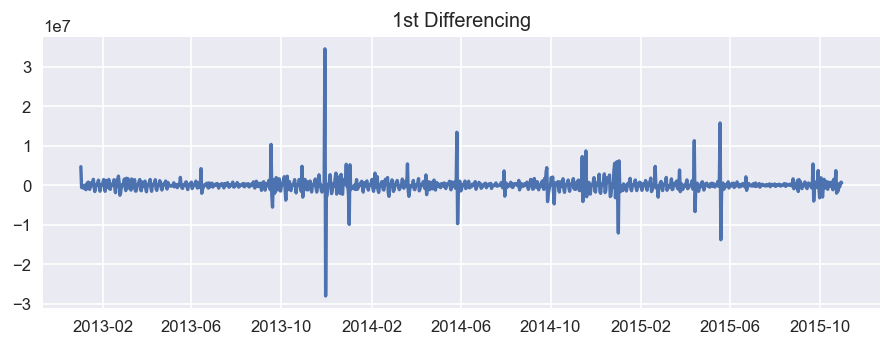

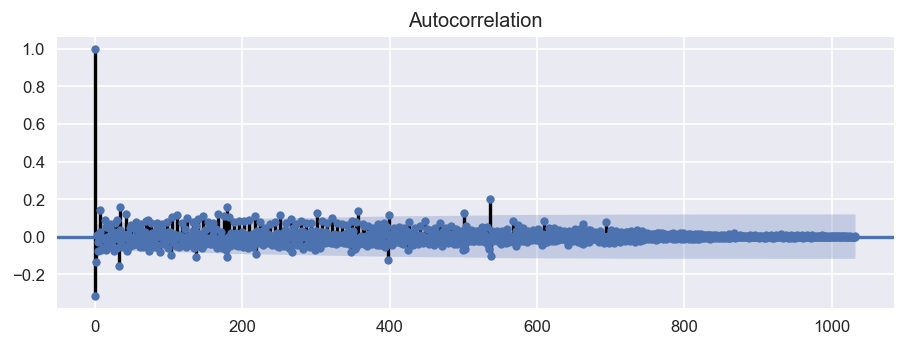

In [105]:
# fig, axes = plt.subplots(1, 2, sharex=True)

plt.plot(ts.diff()); 
plt.title('1st Differencing')

#axes[1].set(ylim=(0,1.2))

acf = plot_acf(ts.diff().dropna())

Even with lag 1 the autocorrelation is going negative

So, let’s tentatively fix q as 0. 

# build the ARIMA Model

Now that we've determined the values of p, d and q, we have everything needed to fit the ARIMA model. 

Let’s use the ARIMA() implementation in statsmodels package.

    we will consider d = 0 (later we can try with 1)
    we will consider p = 0 
    we will consider q = 0 

#### ARIMA with default settings of {0 , 0 , 0}

In [106]:
mod_default = sm.tsa.statespace.SARIMAX(ts,
                                order=(0, 0, 0),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_default = mod_default.fit()

In [107]:
print(results_default.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0691      0.033      2.062      0.039       0.003       0.135
ma.S.L12      -0.8366      0.024    -34.792      0.000      -0.884      -0.789
sigma2      6.471e+12   7.07e-15   9.15e+26      0.000    6.47e+12    6.47e+12


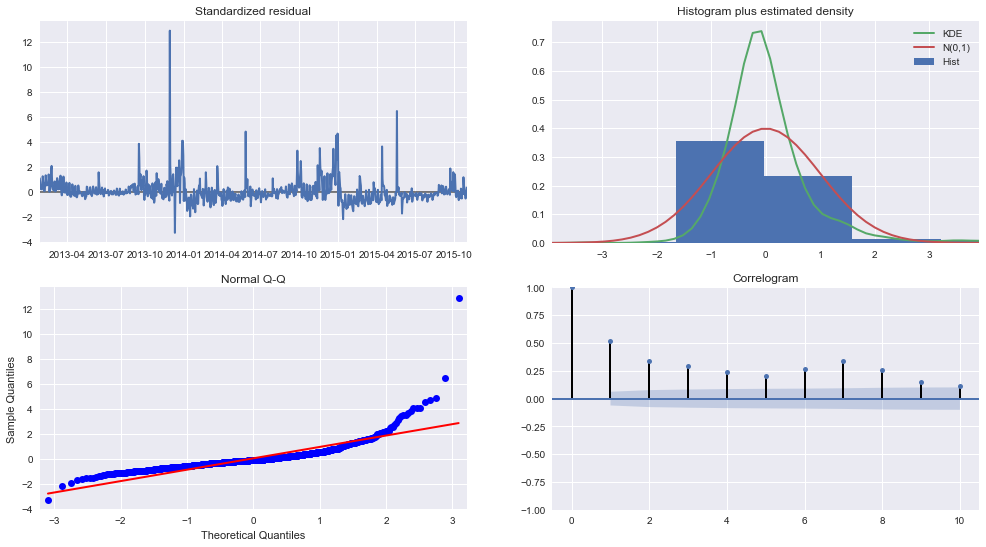

In [701]:
residuals_default = results_default.plot_diagnostics(figsize=(15, 9))

In [108]:
pred_default = results_default.get_prediction(start=pd.to_datetime('2015-08-01'), dynamic=False)

In [109]:
pred_default_ci = pred_default.conf_int()

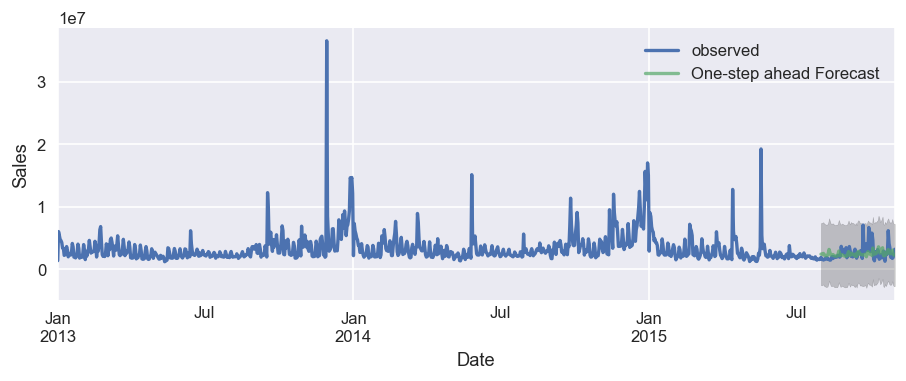

In [110]:
ax = data_grouped.loc['2013':]['Sales'].plot(label='observed')

pred_default.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_default_ci.index,
                pred_default_ci.iloc[:, 0],
                pred_default_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend();

In [111]:
# Predicted sales values
y_forecasted_default = pred_default.predicted_mean

# actual sales values
y_truth_default = data_grouped.loc['2015-08-01':]['Sales']

In [112]:
# Compute the mean abs % error
mape = (abs((y_forecasted_default - y_truth_default) /y_truth_default).mean())*100
print('The Mean Abs percentage Error of our forecasts is {}%'.format(round(mape, 2)))

The Mean Abs percentage Error of our forecasts is 31.24%


the MAPE is slighly above the expected benchmark of 25%. Since we took the defaults 0,0,0 parameters for ARIMA, MAPE is high.

# let us try the best parameter search for the ARIMA model ...

## (1) Parameter Selection for the ARIMA Time Series Model

- When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. 

- There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. 

- We will use a "grid search" to iteratively explore different combinations of parameters. 

- For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. 

- Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. 

In [113]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [114]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [115]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [116]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. 

In Statistics and Machine Learning, this process is known as __grid search (or hyperparameter optimization)__ for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. 

We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. 

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. 

Therefore, we are interested in finding the model that yields the lowest AIC value.

In [119]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

results_params = []
results_aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order       =param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            results_params.append(str(param) +'x'+ str(param_seasonal))
            results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:33604.551092825204
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:32472.024035734124
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:33188.26312577927
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:32839.21792724845
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:32725.522389709517
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:32467.35415281332
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:33766.170401828334
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:33277.03600460096
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:33086.11863766557
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:32301.73301604058
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:33265.63076285686
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:33096.959093371595
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:32546.759049399727
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:32303.081550467334
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:32635.302115708044
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:32360.320087116375
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:32666.217563019163
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:32637.244781420013

In [120]:
results_params_aic = zip(results_params, results_aic)

In [121]:
# Sort the feature importances by most important first
results_params_aic = sorted(results_params_aic, key = lambda x: x[1], reverse = False)
results_params_aic[:5]

[('(1, 0, 1)x(1, 1, 1, 12)', 32192.51861023502),
 ('(1, 0, 1)x(0, 1, 1, 12)', 32193.143639790578),
 ('(1, 1, 1)x(1, 1, 1, 12)', 32228.27209715963),
 ('(1, 1, 1)x(0, 1, 1, 12)', 32229.18975186592),
 ('(1, 0, 0)x(0, 1, 1, 12)', 32251.81879417893)]

The output of our code suggests that SARIMAX(1, 0, 1)x(1, 1, 1, 12) yields the lowest AIC value of 32192.51. 

We should therefore consider this to be optimal option out of all the models we have considered.

## (2) Fitting an ARIMA Time Series Model

In [122]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [123]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9398      0.023     40.001      0.000       0.894       0.986
ma.L1         -0.6266      0.048    -13.024      0.000      -0.721      -0.532
ar.S.L12      -0.0742      0.091     -0.814      0.416      -0.253       0.105
ma.S.L12      -0.9659      0.018    -54.316      0.000      -1.001      -0.931
sigma2      6.937e+12   4.08e-15    1.7e+27      0.000    6.94e+12    6.94e+12


- The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. 

- The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.(except ar.S.L12, lag 2

- When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

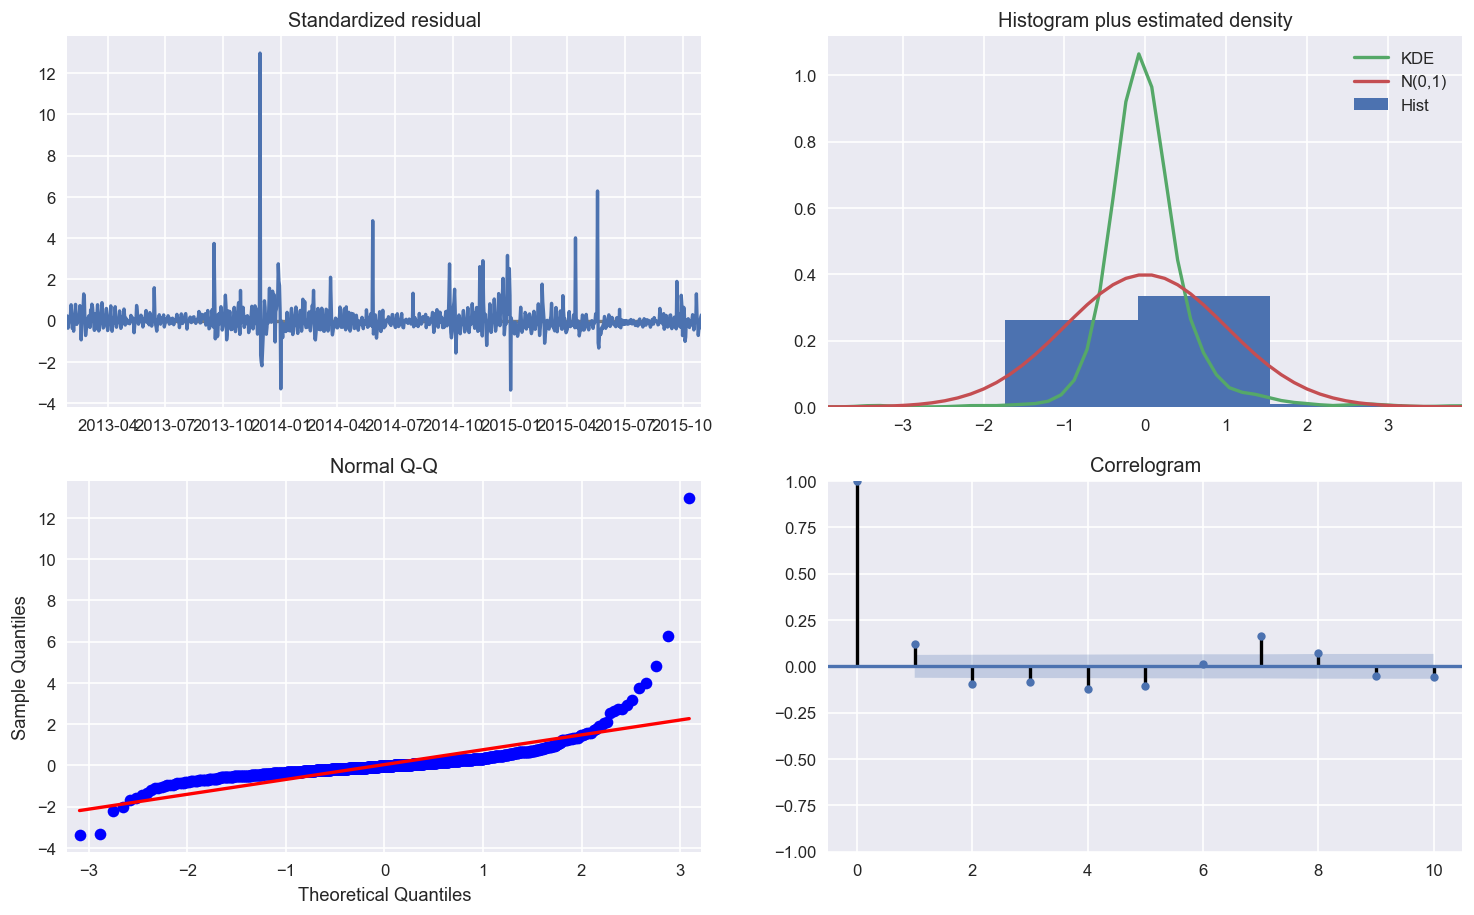

In [124]:
residuals = results.plot_diagnostics(figsize=(15, 9))

- Our primary concern is to ensure that the residuals of our model are 
    - uncorrelated and 
    - normally distributed with zero-mean. 
    
- If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

- In this case, our model diagnostics suggests that the model residuals are normally distributed. Plus more observations as follows:-

    - In the top right plot, we see that the red KDE line really does not follow closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). Hence the residual plots are not perfectly normally distributed.
    
    - The qq-plot on the bottom left shows that the moderately ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is not really a strong indication that the residuals are normally distributed.
       
Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

> Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.
    

# Validating Forecasts

We have obtained a model for our time series that can now be used to produce forecasts. 

We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts

The __get_prediction()__ and __conf_int()__ attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [125]:
pred = results.get_prediction(start=pd.to_datetime('2015-08-01'), dynamic=False)

In [126]:
pred_ci = pred.conf_int()

The code above requires the forecasts to start at 01 AUG 2015.

In [127]:
# data_grouped['Sales']

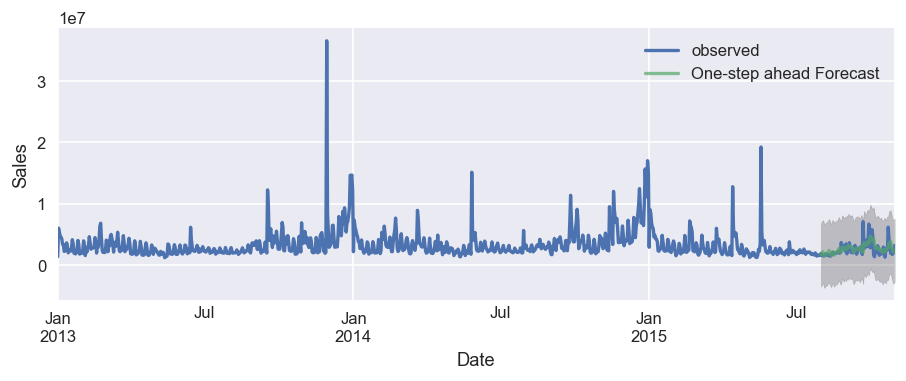

In [128]:
ax = data_grouped.loc['2013':]['Sales'].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend();

Overall, our forecasts align with the true values very well,

## Accuracy of prediction (metrics)

#### MSE (Mean Squared Error)

- which summarizes the average error of our forecasts.
- For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [590]:
# Predicted sales values
y_forecasted = pred.predicted_mean

# actual sales values
y_truth = data_grouped.loc['2015-08-01':]['Sales']

In [592]:
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1068745436605.93
The Root Mean Squared Error of our forecasts is 1033801.45


#### MAPE (Mean absolute % error)

In [599]:
# Compute the mean abs % error
mape = (abs((y_forecasted - y_truth) /y_truth).mean())*100
print('The Mean Abs percentage Error of our forecasts is {}%'.format(round(mape, 2)))

The Mean Squared Error of our forecasts is 25.98%


## dynamic forecasts
dynamic=True

In [615]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-08-01'), dynamic=True)

In [616]:
pred_dynamic_ci = pred.conf_int()

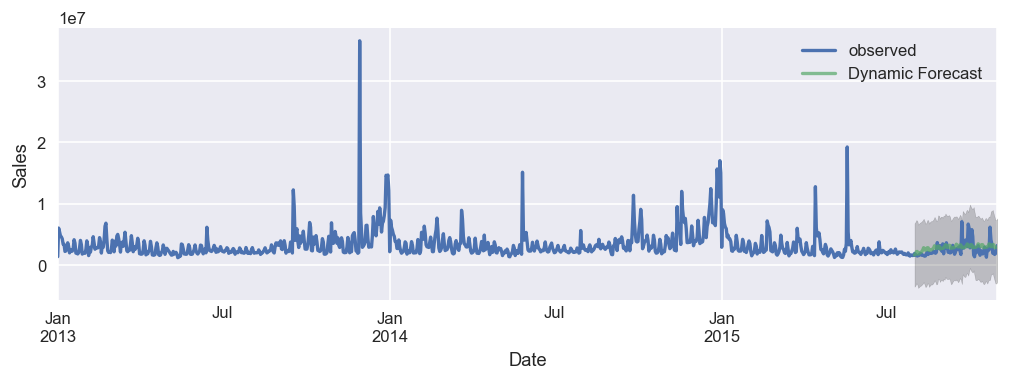

In [617]:
ax = data_grouped.loc['2013':]['Sales'].plot(label='observed')

pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=.7)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend();

Even with dynamic forecast, the predictions are pretty aligned with the actuals

let us validate the metrics ..

In [618]:
# Predicted sales values
y_forecasted = pred_dynamic.predicted_mean

# actual sales values
y_truth = data_grouped.loc['2015-08-01':]['Sales']

In [619]:
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 1200391086998.96
The Root Mean Squared Error of our forecasts is 1095623.61


In [620]:
# Compute the mean abs % error
mape = (abs((y_forecasted - y_truth) /y_truth).mean())*100
print('The Mean Abs percentage Error of our forecasts is {}%'.format(round(mape, 2)))

The Mean Squared Error of our forecasts is 34.44%


The MAPE is slightly higher with dynamic forecast, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. 

# Producing and Visualizing future Forecasts

- The get_forecast() attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [621]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

In [622]:
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

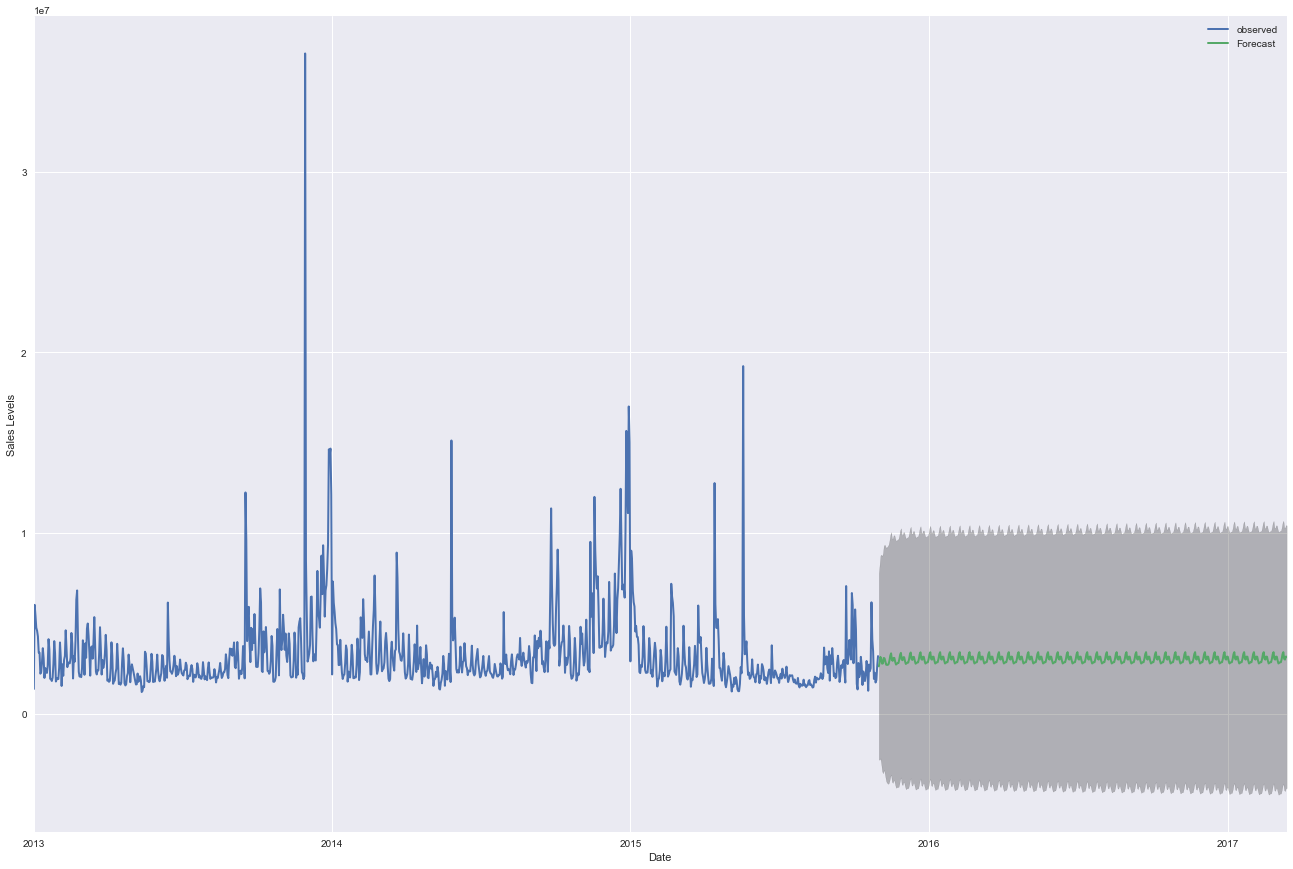

In [696]:
ax = data_grouped['Sales'].plot(label='observed', figsize=(20, 15))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Sales Levels')

plt.legend();

- Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. 

- Our forecasts show that the time series is expected to continue at the same steady pace.

- As we forecast further out into the future, it is natural for us to become less confident in our values. 

- This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

# Future improvements

Here are a few other things we should try:

(1) Change the start date of the  dynamic forecasts to see how this affects the overall quality of your forecasts.


(2) Try more combinations of parameters to see if we can improve the goodness-of-fit of the model.


(3) Select a different metric to select the best model. For example, we used the AIC measure to find the best model, but you could seek to optimize the out-of-sample mean square error instead.

(4) Try using rolling mean or EWMA (to weed out the outliers and noise in the data)

(5) resample TS at weekly level or monthly level

(6) this time series came as STATIONARY by default. Hence there was no need to carry out any specific noise removal techniques. May be we can try some other retail chain sales datasets 